In [1]:
# standard libraries
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, norm
from scipy import linalg, stats
from particles import resampling as rs
import time
from scipy.spatial.distance import cdist
import importlib
from scipy.special import logsumexp
import sys
sys.path.append('..')

In [2]:
def gradient_mixture(x, ms, Sigmas, Sigmas_inv, weights):
    gradient = np.zeros(x.shape)
    denominator = np.zeros((weights.size, x.shape[1]))
    for j in range(weights.size):
        denominator[j, :] = weights[j]*multivariate_normal.pdf(x.T, ms[j,:], Sigmas[j,:,:])
        gradient += -denominator[j, :]*np.matmul(Sigmas_inv[j,:,:],(x.T-ms[j,:]).T)
    return gradient/np.sum(denominator, axis = 0)

def logpi_mixture(x, ms, Sigmas, weights):
    logpi = np.zeros((weights.size, x.shape[1]))
    for j in range(weights.size):
        logpi[j, :] = weights[j]*multivariate_normal.pdf(x.T, ms[j,:], Sigmas[j,:,:])
    return np.log(np.sum(logpi, axis = 0))

In [15]:
def SMC_WFR(gamma, Niter, ms, Sigmas, Sigmas_inv, weights, X0):
    d = ms[0,:].size
    N = X0.shape[0]
    X = np.zeros((Niter, d, N))
    W = np.zeros((Niter, N))
    X[0, :] = X0.T
    W[0, :] = np.ones(N)/N
    for n in range(1, Niter):
        if (n > 1):
            # resample
            ancestors = rs.resampling('stratified', W[n-1, :])
            X[n-1, :, :] = X[n-1, :, ancestors].T
        # MCMC move
        gradient_step = X[n-1, :, :] + gamma*gradient_mixture(X[n-1, :, :], ms, Sigmas, Sigmas_inv, weights)
        X[n, :, :] = gradient_step + np.sqrt(2*gamma)*np.random.normal(size = (d, N))
        # reweight
        distSq = -(1.0 / (4 * gamma))*cdist(X[n, :, :].T, gradient_step.T, metric='sqeuclidean')
        weight_denominator = logsumexp(distSq, axis=1)
        logW = (1-np.exp(-gamma))*(logpi_mixture(X[n, :, :], ms, Sigmas, weights)-weight_denominator)
        W[n, :] = rs.exp_and_normalise(logW)
    return X, W

def SMC_ULA(gamma, Niter, ms, Sigmas, Sigmas_inv, weights, X0):
    d = ms[0,:].size
    N = X0.shape[0]
    X = np.zeros((Niter, d, N))
    X[0,:,:] = X0.T
    W = np.zeros((Niter, N))
    W[0, :] = np.ones(N)/N
    for n in range(1, Niter):
        if (n > 1):
            # resample
            ancestors = rs.resampling('stratified', W[n-1, :])
            X[n-1, :, :] = X[n-1, :, ancestors].T
        # MCMC move
        gradient_step = X[n-1, :, :] + gamma*gradient_mixture(X[n-1, :, :], ms, Sigmas, Sigmas_inv, weights)
        X[n, :, :] = gradient_step + np.sqrt(2*gamma)*np.random.normal(size = (d, N))
        # reweight
        delta = (1-np.exp(-gamma))*np.exp(-(n-1)*gamma)
        logW = delta*(logpi_mixture(X[n, :, :], ms, Sigmas, weights) +0.5*np.sum(X[n, :, :]**2, axis = 0))
        W[n, :] = rs.exp_and_normalise(logW)
    return X, W

def SMC_MALA(gamma, Niter, ms, Sigmas, Sigmas_inv, weights, X0):
    d = ms[0,:].size
    N = X0.shape[0]
    X = np.zeros((Niter, d, N))
    X[0,:,:] = X0.T
    W = np.zeros((Niter, N))
    W[0, :] = np.ones(N)/N
    for n in range(1, Niter):
        if (n > 1):
            # resample
            ancestors = rs.resampling('stratified', W[n-1, :])
            X[n-1, :, :] = X[n-1, :, ancestors].T
        # MCMC move
        gradient_step = X[n-1, :, :] + gamma*gradient_mixture(X[n-1, :, :], ms, Sigmas, Sigmas_inv, weights)
        prop = gradient_step + np.sqrt(2*gamma)*np.random.normal(size = (d, N))
        X[n, :, :], _ = mala_accept_reject(prop, X[n-1, :, :], ms, Sigmas, Sigmas_inv, weights, gamma)
        # reweight
        delta = np.exp(-(n-1)*gamma)
        logW = delta*(logpi_mixture(X[n-1, :, :], ms, Sigmas, weights) +0.5*np.sum(X[n-1, :, :]**2, axis = 0)) - delta*np.exp(-gamma)*(logpi_mixture(X[n, :, :], ms, Sigmas, weights) +0.5*np.sum(X[n, :, :]**2, axis = 0))
        W[n, :] = rs.exp_and_normalise(logW)
    return X, W

def mala_accept_reject(prop, v, ms, Sigmas, Sigmas_inv, weights, gamma):
    d = ms[0,:].size
    log_proposal = multivariate_normal.logpdf((v-(prop+gamma*gradient_mixture(prop, ms, Sigmas, Sigmas_inv, weights))).T, np.zeros(d), 2*gamma*np.eye(d))-multivariate_normal.logpdf((prop - (v+gamma*gradient_mixture(v, ms, Sigmas, Sigmas_inv, weights))).T, np.zeros(d), 2*gamma*np.eye(d))
    log_acceptance = logpi_mixture(prop, ms, Sigmas, weights) - logpi_mixture(v, ms, Sigmas, weights) + log_proposal
    accepted = np.log(np.random.uniform(size = v.shape[1])) <= log_acceptance
    output = np.copy(v)
    output[:, accepted] = prop[:, accepted]
    return output, accepted

In [4]:
w = 1/2
sigma = 1
weights = np.array([w, 1-w])

In [5]:
m = 6
d = 1
LSI = 1 + (np.exp(m**2)+1)/2
LSI

2155615773557599.0

In [6]:
def gm1d_density(xx, m, w):
    return w*norm.pdf(xx, loc = 0, scale = 1) + (1-w)*norm.pdf(xx, loc = m, scale = 1)

xx = np.linspace(-3, 10, 100)
yy = gm1d_density(xx, m, w)
dx = xx[1]-xx[0]

In [7]:
ms = np.array([np.zeros(d), m*np.ones(d)])
Sigmas = np.array([sigma*np.eye(d), sigma*np.eye(d)])
Sigmas_inv = np.array([linalg.inv(Sigmas[0,:,:]), linalg.inv(Sigmas[1,:,:])])

In [8]:
N = 1000
X0 = np.random.multivariate_normal(np.zeros(d), np.eye(d), size = N)
Niter = 5000
gamma = 0.01

In [9]:
### SMC-WFR
start = time.time()
wfr_x, wfr_w = SMC_WFR(gamma, Niter, ms, Sigmas, Sigmas_inv, weights, X0)
end = time.time()
end-start

31.67655301094055

In [11]:
### SMC-ULA
start = time.time()
smcula_x, smcula_w = SMC_ULA(gamma, Niter, ms, Sigmas, Sigmas_inv, weights, X0)
end = time.time()
end-start

1.7283031940460205

In [16]:
### SMC-MALA
start = time.time()
smcmala_x, smcmala_w = SMC_MALA(gamma, Niter, ms, Sigmas, Sigmas_inv, weights, X0)
end = time.time()
end-start

5.78935694694519

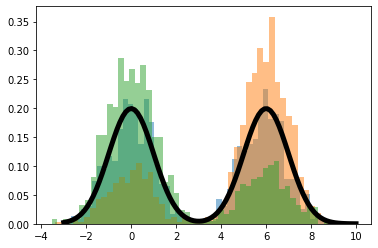

In [17]:
plt.hist(wfr_x[-1, :, :].flatten(), density = True, weights = wfr_w[-1, :], bins = 50, alpha = 0.5);
plt.hist(smcula_x[-1, :, :].flatten(), density = True, weights = smcula_w[-1, :], bins = 50, alpha = 0.5);
plt.hist(smcmala_x[-1, :, :].flatten(), density = True, weights = smcmala_w[-1, :], bins = 50, alpha = 0.5);
plt.plot(xx, yy, c = 'black', lw = 5)

In [18]:
kl_wfr = np.zeros(Niter)
kl_smcula = np.zeros(Niter)
kl_smcmala = np.zeros(Niter)
for j in range(Niter):
    kde_wfr = stats.gaussian_kde(wfr_x[j, :], weights = wfr_w[j, :])
    kl_wfr[j] = dx*np.sum(kde_wfr(xx)*(np.log(kde_wfr(xx))-np.log(yy)))
    kde_smcula = stats.gaussian_kde(smcula_x[j, :], weights = smcula_w[j, :])
    kl_smcula[j] = dx*np.sum(kde_smcula(xx)*(np.log(kde_smcula(xx))-np.log(yy)))
    kde_smcmala = stats.gaussian_kde(smcmala_x[j, :], weights = smcmala_w[j, :])
    kl_smcmala[j] = dx*np.sum(kde_smcmala(xx)*(np.log(kde_smcmala(xx))-np.log(yy)))

Text(0, 0.5, 'KL$_t$')

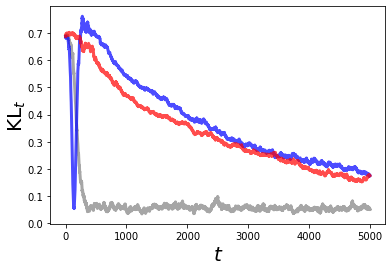

In [19]:
plt.plot(kl_wfr, label = 'SMC-WFR', color = 'gray', alpha = 0.7, lw = 3)
plt.plot(kl_smcula, label = 'SMC-ULA', color = 'blue', alpha = 0.7, lw = 3)
plt.plot(kl_smcmala, label = 'SMC-MALA', color = 'red', alpha = 0.7, lw = 3)
plt.xlabel('$t$', fontsize = 20)
plt.ylabel('KL$_t$', fontsize = 20, labelpad=-1)
# plt.savefig('SMC_WFR_gaussianmix_alternatives.pdf', bbox_inches="tight")